In [1]:
import os
import warnings
from flask import Flask, render_template, make_response, request
from twilio.rest import Client
from dotenv import load_dotenv
import requests
import json
import numpy as np
import io
import pickle
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from pydub import AudioSegment
from pydub.silence import split_on_silence
import speech_recognition as sr
import aubio
import parselmouth
from parselmouth.praat import call

d:\Aayush\Aayush\Mental Health Project\OneDrive_2024-05-14\mental health\.venv\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
load_dotenv()  # load environment variables

TWILIO_ACCOUNT_SID = os.environ["TWILIO_ACCOUNT_SID"]
TWILIO_AUTH_TOKEN = os.environ["TWILIO_AUTH_TOKEN"]
twilio_api = Client(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)

with open("D:/Aayush/Aayush/Mental Health Project/OneDrive_2024-05-14/mental health/rf_model.pkl", 'rb') as model_file:
    model = pickle.load(model_file)

app = Flask(__name__)
# print(type(model))

In [3]:
page_url = f"https://api.twilio.com/2010-04-01/Accounts/{TWILIO_ACCOUNT_SID}/Recordings.json"
# print(page_url)
recording_response = twilio_api.http_client.request("GET", page_url, auth=(TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN))
# print(recording_response.content)
data = json.loads(recording_response.content)
recording_sids = [recording["sid"] for recording in data.get("recordings", [])]
# recording_sids

In [4]:
end = 1
start = 0
if end > len(recording_sids):
    end = len(recording_sids)

sub_recordings = recording_sids[start:end]
# print(sub_recordings)
recordings_with_emotion = []

In [5]:
import wave
def create_wav_file(audio_content):
    a = io.BytesIO(audio_content)
    audio_data = a.getvalue()
    nchannels = 1  # number of audio channels (1 for mono, 2 for stereo)
    sampwidth = 2  # sample width in bytes (1 for 8-bit, 2 for 16-bit, etc.)
    framerate = 8000  # frames per second
    nframes = len(audio_data) // (sampwidth * nchannels)  # number of frames

    # # Create a new WAV file
    with wave.open("temp_audio_1.wav", "wb") as audio:
        audio.setnchannels(nchannels)
        audio.setsampwidth(sampwidth)
        audio.setframerate(framerate)
        audio.setnframes(nframes)
        audio.writeframes(audio_data)

    print("WAV file written successfully.")
    # print(type(audio))
    audio_file_path = "temp_audio_1.wav"  # Temporary file path for audio
    return audio_file_path


In [6]:
for recording_sid in sub_recordings:
    recording_url = f"https://api.twilio.com/2010-04-01/Accounts/{TWILIO_ACCOUNT_SID}/Recordings/{recording_sid}.wav"
    print(recording_url)
    auth = (TWILIO_ACCOUNT_SID, TWILIO_AUTH_TOKEN)
    response = requests.get(recording_url, auth=auth)
    # print(response.status_code)
    # print(response.content)
    if response.status_code == 200:
        # Process the recording using your emotion prediction model
        audio_file_path = create_wav_file(response.content)

https://api.twilio.com/2010-04-01/Accounts/ACf6824a516890c2af9fe97dd44e79e887/Recordings/REe4b53708966e59b06b18f445ad4ce080.wav


WAV file written successfully.


In [7]:
def plot_amplitude_vs_time(audio_file_path):
    # Open the WAV file
    normal_wav_file = wave.open(audio_file_path, 'r')

    # Get the number of frames and the sample rate
    num_frames = normal_wav_file.getnframes()
    sample_rate = normal_wav_file.getframerate()
    num_channels = normal_wav_file.getnchannels()

    # Read the frames and convert them to a numpy array
    frames = normal_wav_file.readframes(num_frames)
    audio_data = np.frombuffer(frames, dtype=np.int16)

    # If the audio is stereo, reshape the array
    if num_channels == 2:
        audio_data = audio_data.reshape(-1, 2)

    # Use only the first channel if stereo
    if num_channels == 2:
        audio_data = audio_data[:, 0]

    # Calculate the time axis
    time = np.arange(0, len(audio_data)) / sample_rate

    # Plot the amplitude vs time graph
    plt.plot(time, audio_data)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Amplitude vs Time')
    plt.show()

    # Close the WAV file
    normal_wav_file.close()

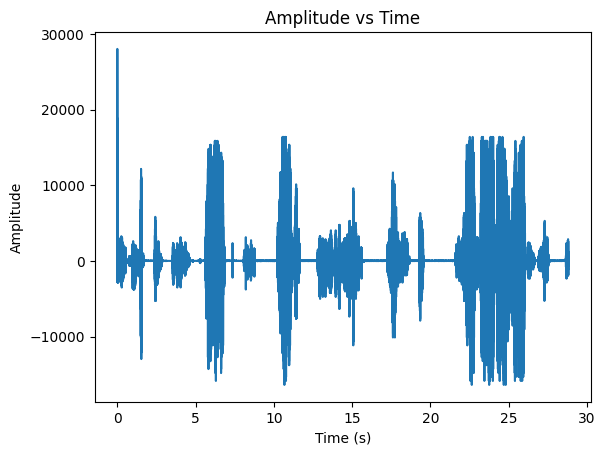

In [8]:
plot_amplitude_vs_time(audio_file_path)

In [9]:
def calculate_loudness(audio_file_path, window_size=1024, overlap=512):
    # Open the WAV file
    normal_wav_file = wave.open(audio_file_path, 'r')

    # Get the number of frames and the sample rate
    num_frames = normal_wav_file.getnframes()
    sample_rate = normal_wav_file.getframerate()
    num_channels = normal_wav_file.getnchannels()

    # Read the frames and convert them to a numpy array
    frames = normal_wav_file.readframes(num_frames)
    audio_data = np.frombuffer(frames, dtype=np.int16)

    # If the audio is stereo, reshape the array
    if num_channels == 2:
        audio_data = audio_data.reshape(-1, 2)
        # Use only the first channel if stereo
        audio_data = audio_data[:, 0]

    # Close the WAV file
    normal_wav_file.close()

    # Initialize lists to store time and loudness values
    times = []
    loudness_values = []

    # Calculate the loudness over time using RMS
    step_size = window_size - overlap
    for start in range(0, len(audio_data) - window_size + 1, step_size):
        window = audio_data[start:start + window_size]
        rms = np.sqrt(np.mean(window.astype(np.float32) ** 2))
        loudness = 20 * np.log10(rms / 32768.0)
        times.append(start / sample_rate)
        loudness_values.append(loudness)

    # Plot the loudness vs time graph
    plt.plot(times, loudness_values)
    plt.xlabel('Time (s)')
    plt.ylabel('Loudness (dB)')
    plt.title('Loudness vs Time')
    plt.show()

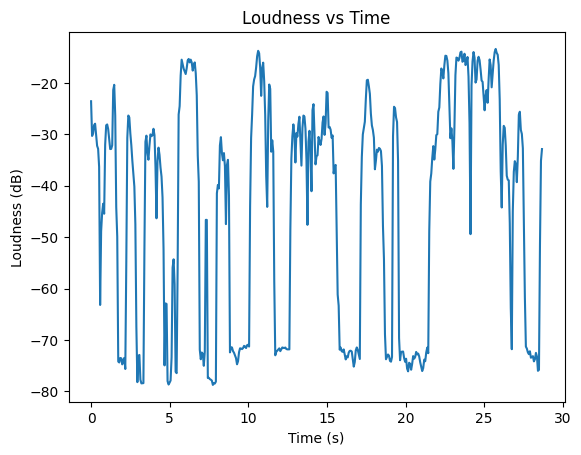

In [10]:
calculate_loudness(audio_file_path)

In [22]:
def measurePitch(voiceID, f0min = 75, f0max = 500, unit = "Hertz"):
    sound = parselmouth.Sound(voiceID) # read the sound
    duration = call(sound, "Get total duration") # duration
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    return meanF0, stdevF0, hnr, localJitter, localShimmer

In [23]:
meanF0, stdevF0, hnr, localJitter, localShimmer = measurePitch(audio_file_path)

In [25]:
print(localShimmer)

0.12504926480626097


In [31]:
def create_hist(file_path, feature):
    data = pd.read_csv(file_path)

    # Filter the data
    data_less_50 = data[data['SDS Score'] < 50]
    data_more_equal_50 = data[data['SDS Score'] >= 50]

    # Plot histograms
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Histogram for sds < 50
    axs[0].hist(data_less_50[feature], bins=20, color='blue', edgecolor='black', weights=[100 / len(data_less_50)] * len(data_less_50))
    axs[0].set_title(f"Percentage Histogram of {feature} (sds < 50)")
    axs[0].set_xlabel(f"{feature}")
    axs[0].set_ylabel('Percentage')

    # Histogram for sds >= 50 (normalized to show percentage)
    axs[1].hist(data_more_equal_50[feature], bins=20, color='green', edgecolor='black', weights=[100 / len(data_more_equal_50)] * len(data_more_equal_50))
    axs[1].set_title('Percentage Histogram of f0 (sds >= 50)')
    axs[1].set_xlabel(f"{feature}")

    # Show the plot
    plt.tight_layout()
    plt.show()

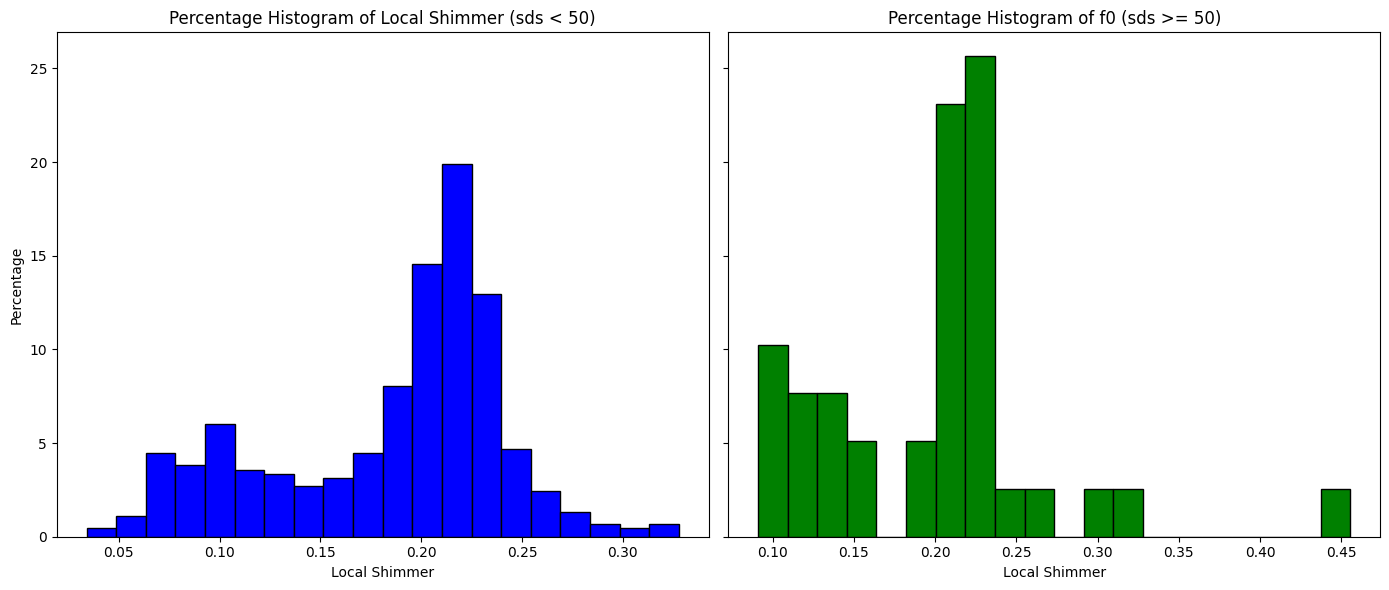

In [33]:
create_hist("new_csv.csv", 'Local Shimmer')

In [11]:
from scipy.signal import spectrogram
from matplotlib.colors import ListedColormap

def plot_spectrogram(audio_file_path):
    # Open the WAV file
    normal_wav_file = wave.open(audio_file_path, 'r')

    # Get the number of frames, the sample rate, and the number of channels
    num_frames = normal_wav_file.getnframes()
    sample_rate = normal_wav_file.getframerate()
    num_channels = normal_wav_file.getnchannels()

    # Read the frames and convert them to a numpy array
    frames = normal_wav_file.readframes(num_frames)
    audio_data = np.frombuffer(frames, dtype=np.int16)

    # If the audio is stereo, reshape the array
    if num_channels == 2:
        audio_data = audio_data.reshape(-1, 2)

    # Use only the first channel if stereo
    if num_channels == 2:
        audio_data = audio_data[:, 0]

    # Calculate the spectrogram
    frequencies, times, Sxx = spectrogram(audio_data, fs=sample_rate)
    red_white_cmap = ListedColormap(['white', 'red'])
    # Plot the spectrogram
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title('Spectrogram')
    plt.colorbar(label='Intensity (dB)')
    plt.show()

    # Close the WAV file
    normal_wav_file.close()

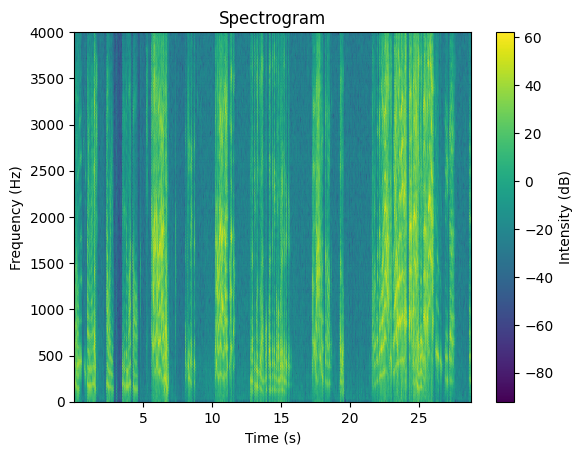

In [12]:
plot_spectrogram(audio_file_path)

In [13]:
import numpy as np
from scipy.signal import stft, resample
import librosa

def plot_f0_vs_time(wave_file):
    # Load the wave file
    audio, sr = librosa.load(wave_file)

    # Calculate the fundamental frequency (f0)
    f0, voiced_flag, _ = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

    # Create a time array
    t = librosa.times_like(f0)

    # Plot waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(np.arange(len(audio)) / sr, audio)
    plt.title('Waveform')

    # Plot f0 vs. time
    plt.subplot(2, 1, 2)
    plt.plot(t, f0, color='r')
    plt.xlabel('Time (s)')
    plt.ylabel('Fundamental Frequency (Hz)')
    plt.title('Fundamental Frequency vs. Time')

    plt.tight_layout()
    plt.show()
    

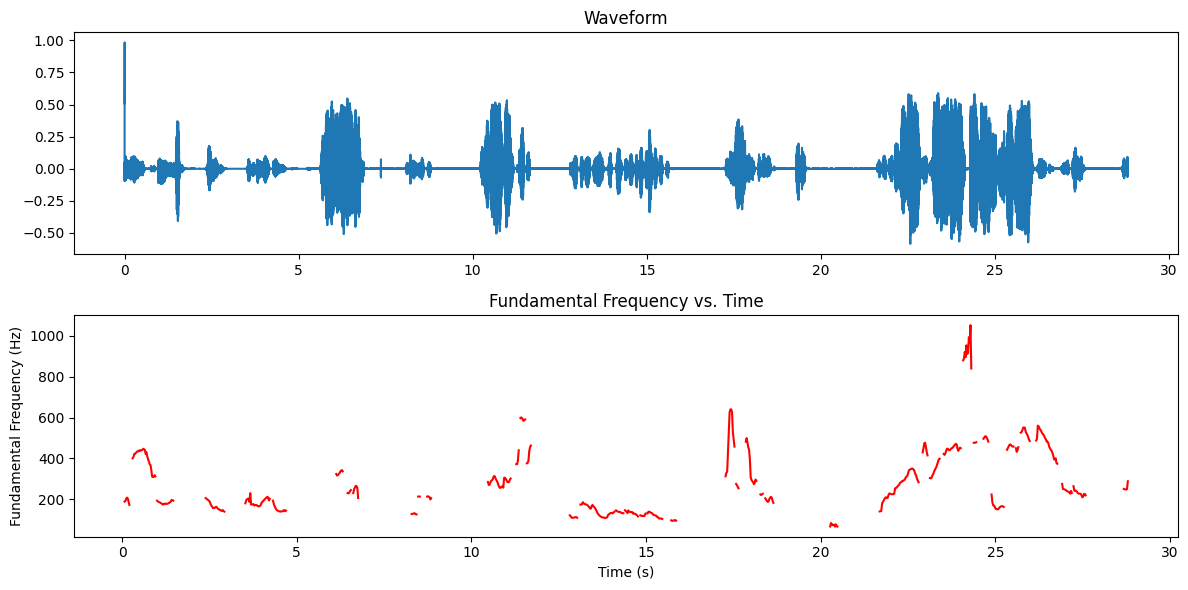

In [14]:
plot_f0_vs_time(audio_file_path)

In [15]:
def calculate_mean_f0(wave_file):
    # Load the wave file
    audio, sr = librosa.load(wave_file)

    # Calculate the fundamental frequency (f0)
    f0, voiced_flag, _ = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))

    # Check if there are any valid f0 values
    if np.isnan(f0).all():
        return None

    # Calculate the mean f0
    mean_f0 = np.nanmean(f0)

    return mean_f0

In [16]:
print(calculate_mean_f0(audio_file_path))

280.14184615158825


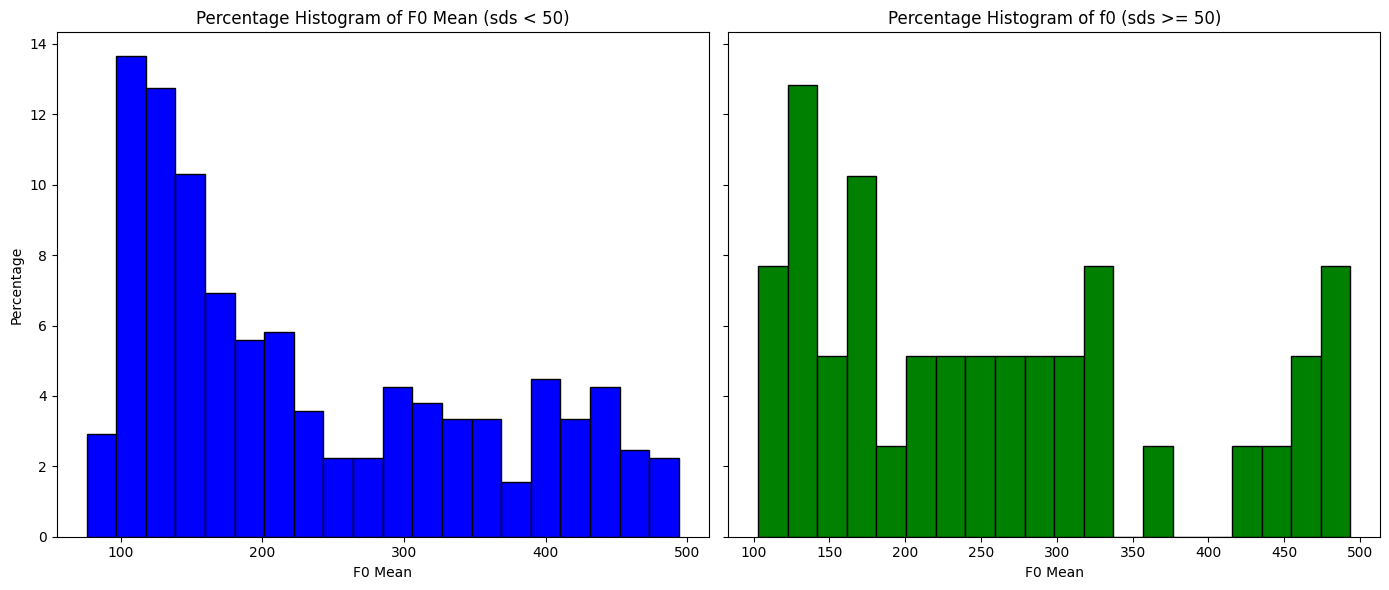

In [35]:
create_hist("new_csv.csv", 'F0 Mean')

In [17]:
def compute_hnr(y, sr, hop_length):
    # Compute the harmonics-to-noise ratio (HNR)
    harmonic = librosa.effects.harmonic(y)
    noise = y - harmonic
    
    harmonic_rms = librosa.feature.rms(y=harmonic, hop_length=hop_length)
    noise_rms = librosa.feature.rms(y=noise, hop_length=hop_length)
    
    hnr = 20 * np.log10(harmonic_rms / noise_rms)
    hnr = hnr.flatten()
    
    return harmonic, noise, hnr

def plot_hnr(wav_file):
    # Load the audio file
    y, sr = librosa.load(wav_file, sr=None)
    
    # Extract the fundamental frequency (F0)
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    
    # Compute the hop length for the analysis
    hop_length = 512
    
    # Compute the harmonic, noise, and HNR
    harmonic, noise, hnr = compute_hnr(y, sr, hop_length)
    
    # Generate time axis for the plots
    times = librosa.times_like(hnr, sr=sr, hop_length=hop_length)
    
    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # Plot Harmonic
    axs[0].plot(np.linspace(0, len(y) / sr, len(harmonic)), harmonic, color='blue')
    axs[0].set_ylabel('Amplitude')
    axs[0].set_title('Harmonic Component')
    axs[0].grid()

    # Plot Noise
    axs[1].plot(np.linspace(0, len(y) / sr, len(noise)), noise, color='red')
    axs[1].set_ylabel('Amplitude')
    axs[1].set_title('Noise Component')
    axs[1].grid()
    
    # Plot HNR
    axs[2].plot(times, hnr, label='HNR (dB)', color='green')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('HNR (dB)')
    axs[2].set_title('Harmonics-to-Noise Ratio (HNR)')
    axs[2].legend()
    axs[2].grid()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

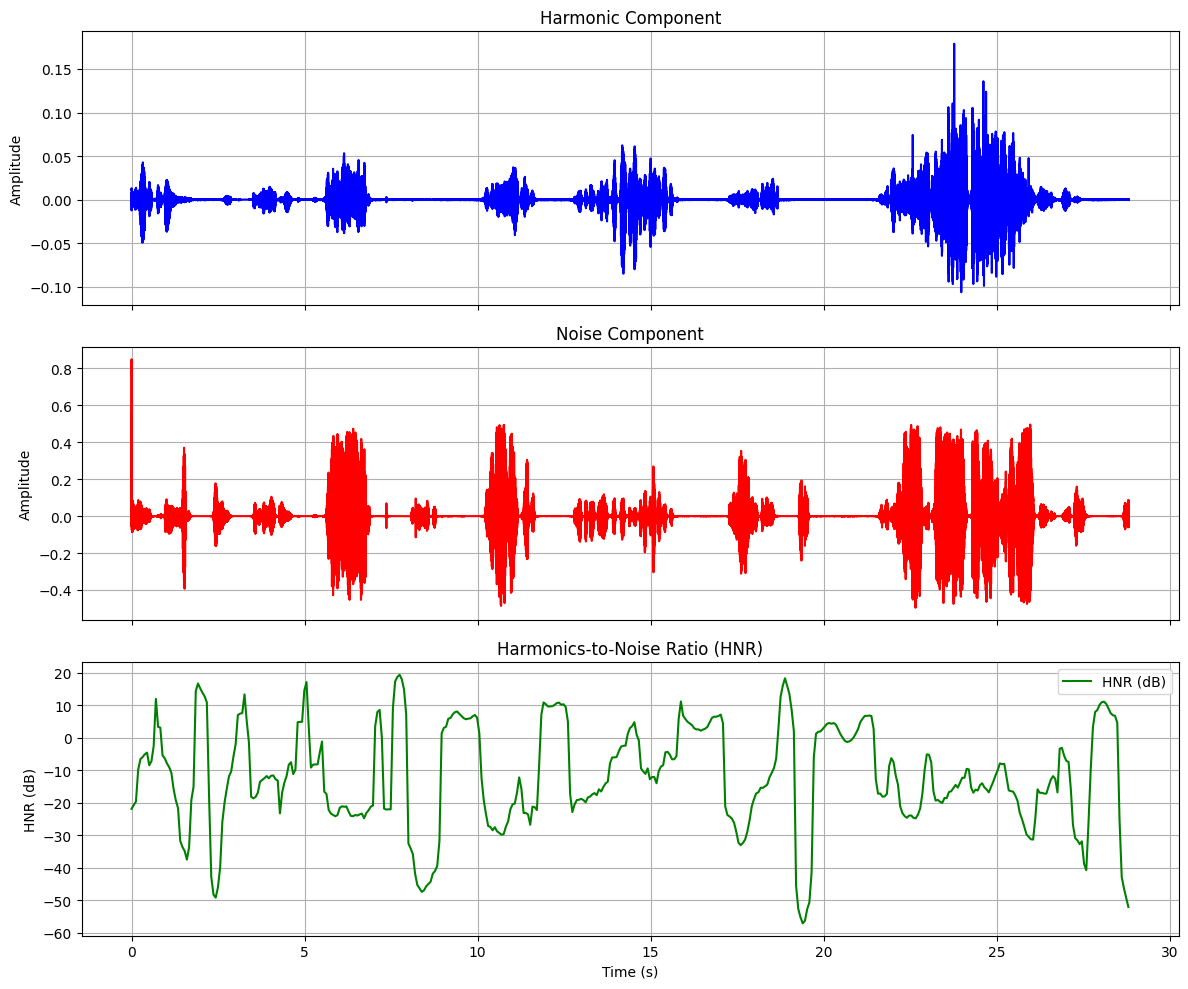

In [18]:
plot_hnr(audio_file_path)

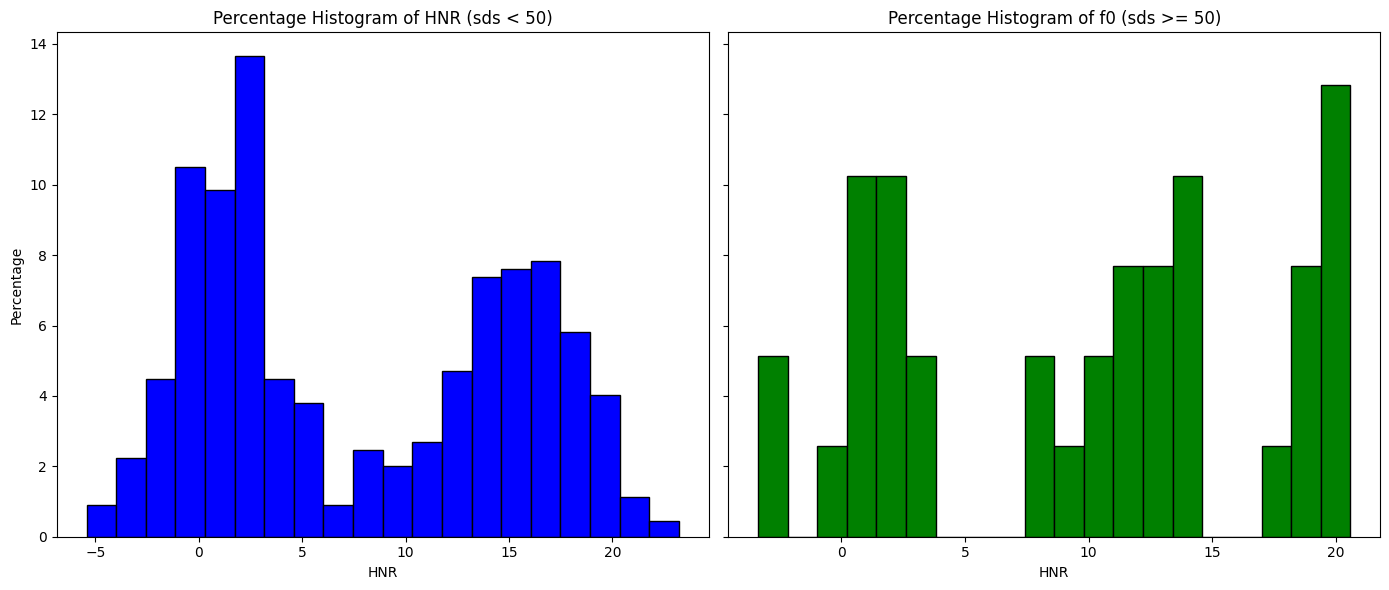

In [36]:
create_hist("new_csv.csv", 'HNR')

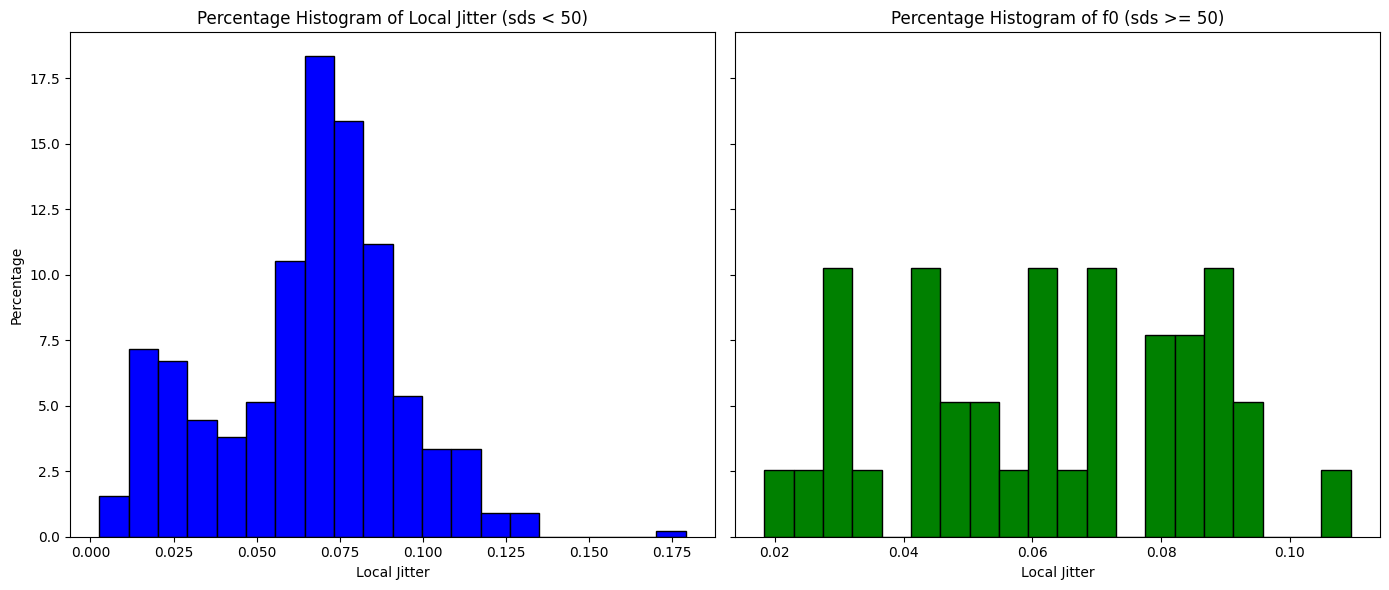

In [37]:
create_hist("new_csv.csv", 'Local Jitter')

In [19]:
def calculate_shimmer(y, sr, f0, hop_length):
    # Ensure the fundamental frequency (f0) is not nan
    f0 = f0[~np.isnan(f0)]
    
    # Identify the indices of the pitch periods
    times = librosa.times_like(f0, sr=sr, hop_length=hop_length)
    pitch_periods = np.diff(times)
    
    # Extract peak amplitudes for each period
    peak_amplitudes = []
    for i in range(len(pitch_periods)):
        start = int(times[i] * sr)
        end = start + int(pitch_periods[i] * sr)
        peak_amplitudes.append(np.max(np.abs(y[start:end])))
    
    peak_amplitudes = np.array(peak_amplitudes)
    
    # Calculate the amplitude differences and normalize
    amplitude_diffs = np.abs(np.diff(peak_amplitudes))
    normalized_diffs = amplitude_diffs / ((peak_amplitudes[:-1] + peak_amplitudes[1:]) / 2)
    
    # Calculate shimmer as the average of normalized differences
    shimmer_percentage = np.mean(normalized_diffs)
    return shimmer_percentage

def calculate_f0(y, sr):
    # Extract the fundamental frequency (F0)
    f0, _, _ = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    return f0

def load_audio_file(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

In [20]:
y, sr = load_audio_file(audio_file_path)
hop_length = 512
f0 = calculate_f0(y, sr)
shimmer = calculate_shimmer(y, sr, f0, hop_length)
print(shimmer)

0.59630686


In [21]:
def calculate_shimmer(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) # create a Praat pitch object
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    shimmer = call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    return shimmer

def plot_shimmer(voiceID, f0min = 75, f0max = 500, unit = "Hertz"):
    sound = parselmouth.Sound(voiceID) # read the sound
    shimmer = calculate_shimmer(voiceID, f0min, f0max, unit)
    if not isinstance(shimmer, list):  # Ensure shimmer is a list or array
        shimmer = [shimmer]  # Convert to list if it's a single float value
    time_step = sound.duration / len(shimmer)
    print(sound.duration, len(shimmer), time_step)
    time_points = np.arange(0, sound.duration, time_step)
    
    print("Shimmer:", shimmer)
    print("Time points:", time_points)
    
    plt.figure(figsize=(10, 5))
    plt.plot(time_points, shimmer, color='blue')
    plt.title('Shimmer over Time')
    plt.xlabel('Time (s)')
    plt.ylabel('Shimmer')
    plt.grid(True)
    plt.show()


# Example usage:
voiceID = "example.wav"
f0min = 75
f0max = 500
unit = "Hertz"


28.814375 1 28.814375
Shimmer: [0.12504926480626097]
Time points: [0.]


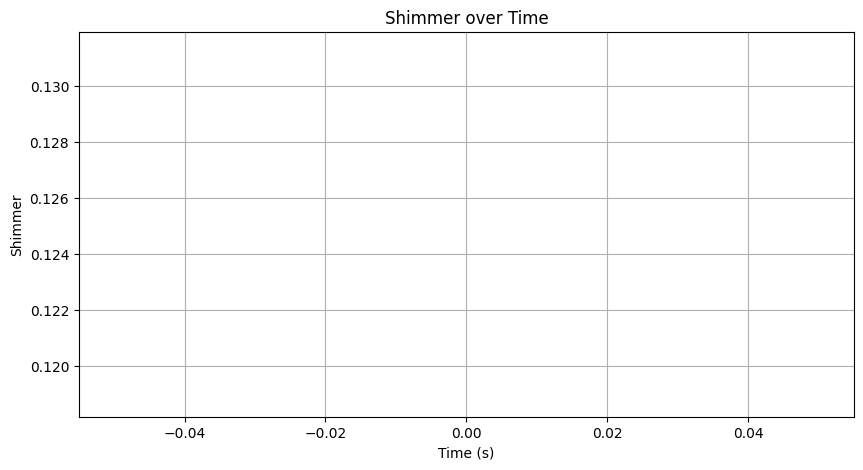

In [128]:
# plot_shimmer(audio_file_path )